In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
import cv2
from skimage import io, img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import threshold_sauvola
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import json
from PIL import Image, ImageFont, ImageDraw
from glob import glob
import matplotlib.patches as patches

## Collecting Annotations

In [2]:
with open('/home/voyagerani/Desktop/BrewTex/Datasets/labels/publaynet/train.json', 'r') as f:
    samples = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/home/voyagerani/Desktop/BrewTex/Datasets/labels/publaynet/train.json'

In [52]:
print(samples['images'][0])
print(samples['annotations'][0])
print(samples['categories'][0])

{'file_name': 'PMC3866684_00003.jpg', 'height': 811, 'id': 0, 'width': 613}
{'segmentation': [[52.38, 444.87, 291.97, 444.87, 291.97, 456.42, 291.97, 456.42, 291.97, 465.8, 291.97, 465.8, 291.97, 476.27, 291.97, 476.27, 291.97, 487.8, 291.97, 487.8, 291.97, 498.26, 86.41, 498.26, 86.41, 508.73, 40.42, 508.73, 40.42, 497.17, 40.42, 497.17, 40.42, 486.71, 40.42, 486.71, 40.42, 476.27, 40.42, 476.27, 40.42, 466.88, 40.42, 466.88, 40.42, 455.33, 52.38, 455.33, 52.38, 444.87]], 'area': 13787.433082525036, 'iscrowd': 0, 'image_id': 0, 'bbox': [40.42, 444.87, 251.55, 63.86], 'category_id': 1, 'id': 0}
{'supercategory': '', 'id': 1, 'name': 'text'}


## Visualising Annotations

In [23]:
# Define color code
colors = {'title': (255, 0, 0),
          'text': (0, 255, 0),
          'figure': (0, 0, 255),
          'table': (255, 255, 0),
          'list': (0, 255, 255)}
font = ImageFont.load_default()

In [24]:
image_id = samples['images'][0]['id']
# print(image_id)

annotation_id = samples['annotations'][0]['image_id']
# print(annotation_id)

annotations_for_image = [annotation for annotation in samples['annotations'] if annotation['image_id'] == image_id]

# print(annotations_for_image)
print(annotations_for_image)

[{'segmentation': [[52.38, 444.87, 291.97, 444.87, 291.97, 456.42, 291.97, 456.42, 291.97, 465.8, 291.97, 465.8, 291.97, 476.27, 291.97, 476.27, 291.97, 487.8, 291.97, 487.8, 291.97, 498.26, 86.41, 498.26, 86.41, 508.73, 40.42, 508.73, 40.42, 497.17, 40.42, 497.17, 40.42, 486.71, 40.42, 486.71, 40.42, 476.27, 40.42, 476.27, 40.42, 466.88, 40.42, 466.88, 40.42, 455.33, 52.38, 455.33, 52.38, 444.87]], 'area': 13787.433082525036, 'iscrowd': 0, 'image_id': 0, 'bbox': [40.42, 444.87, 251.55, 63.86], 'category_id': 1, 'id': 0}, {'segmentation': [[309.91, 444.91, 561.46, 444.91, 561.46, 456.42, 345.43, 456.42, 345.43, 466.88, 309.91, 466.88, 309.91, 456.42, 309.91, 456.42, 309.91, 444.91]], 'area': 3266.252633666969, 'iscrowd': 0, 'image_id': 0, 'bbox': [309.91, 444.91, 251.55, 21.97], 'category_id': 1, 'id': 1}, {'segmentation': [[52.38, 507.66, 291.97, 507.66, 291.97, 519.19, 291.97, 519.19, 291.97, 529.65, 291.97, 529.65, 291.97, 540.11, 40.42, 540.11, 40.42, 528.56, 40.42, 528.56, 40.42, 

In [53]:
def draw_annotations(image_path, annotations_for_image):
    #{[seg, area, iscrowd0, image_id0, bbox], [seg, area, iscrowd0, image_id0, bbox]....}
    image = Image.open(image_path)
    image = image.convert('RGBA')


    draw = ImageDraw.Draw(image, 'RGBA')

    for annotation in annotations_for_image:
        draw.polygon(annotation['segmentation'][0], fill=(0, 255, 0, 20))  # Green with ~20% opacity
        # bbox = annotation['bbox']
        # rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        # ax.add_patch(rect)
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    plt.show()


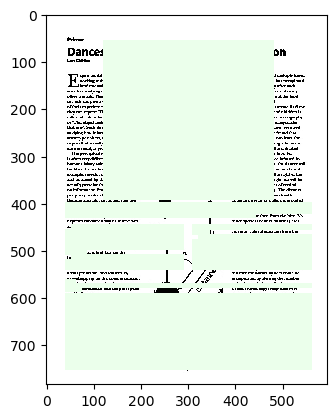

In [54]:
image_path = '/home/voyagerani/Desktop/BrewTex/AI model/Image augmentation/img1.jpg'
draw_annotations(image_path, annotations_for_image)
# cv2.imwrite('/home/voyagerani/Desktop/BrewTex/AI model/Image augmentation/img11.jpg', test_image)

In [17]:
def img_to_numpy(file_path):
    img = cv2.imread(file_path)
    return np.array(img)

def adaptive_mean_threshold(file_path):
    img = img_to_numpy(file_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                          cv2.THRESH_BINARY, 199, 5)
    return thresh

def Normalise_images(file_path):
    thresh = adaptive_mean_threshold(file_path)
    normalized_thresh = cv2.normalize(thresh, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return normalized_thresh

def image_augmentation(file_path):
    thresh = adaptive_mean_threshold(file_path)
    flip_param = iaa.Fliplr(p = 1.0)
    thresh_hflip = flip_param.augment_image(thresh)

    vflip_param = iaa.Flipud(p = 1.0)
    thresh_vflip = vflip_param.augment_image(thresh)

    rot_param = iaa.Affine(rotate=(-60, 20))
    thresh_rot = rot_param.augment_image(thresh)

    crop_param = iaa.Crop(percent = (0, 0.3))
    thresh_crop = crop_param.augment_image(thresh)

    noise_param = iaa.AdditiveGaussianNoise(10, 40)
    thresh_noise = noise_param.augment_image(thresh)

    zoom_param = iaa.Affine(scale=(1.0, 1.5))  # Zoom in by 50%
    thresh_zoom = zoom_param.augment_image(thresh)

    return thresh, thresh_hflip, thresh_vflip, thresh_rot, thresh_crop, thresh_noise, thresh_zoom

def augment_combo(file_path, image, annotations):
    thresh_normalised = Normalise_images(file_path)
    thresh, thresh_hflip, thresh_vflip, thresh_rot, thresh_crop, thresh_noise, thresh_zoom = image_augmentation(file_path)
    
    annotations_for_image = [annotation for annotation in samples['annotations'] if annotation['image_id'] == image_id]
    
    return thresh_normalised